In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
global_map = cv2.imread('/home/dan/MacEwan-Navigation-Bot/remote_setup/ws/resources/building5.pgm')
global_map = cv2.cvtColor(global_map, cv2.COLOR_RGB2GRAY)
local_map = cv2.imread('/home/dan/MacEwan-Navigation-Bot/remote_setup/ws/resources/corner.pgm')
local_map = cv2.cvtColor(local_map, cv2.COLOR_RGB2GRAY)

In [3]:
def imshow(im):
    plt.xticks([]), plt.yticks([])
    plt.imshow(im, cmap="gray")
    plt.show()

In [4]:
def setup_map(im):
    imx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=5)
    imy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=5)
    mag = np.sqrt(imx**2 + imy**2)
    temp = np.ones(im.shape)
    temp[imx == 0] = np.nan
    angle = np.where(temp == 1, np.arctan2(imy, imx), temp)
    return mag, angle


def calc_weight(global_angle, local_angle, local_mag, pose):
    # requires the local map to be rotated
    # global map should be padded with nans 
    local_mag, local_angle = setup_map(local_walls) 
    end_row = pose[0] + local_map.shape[0]
    end_col = pose[1] + local_map.shape[1]
    # crop global map to size of new map
    new_map = np.copy(global_angle[pose[0]+max(local_ang.shape):end_row+max(local_ang.shape), pose[1]+max(local_ang.shape):end_col+max(local_ang.shape)])
    # calc q at
    new_map = 1 - (2 * np.abs(np.arctan(np.sin( local_angle - new_map) / np.cos(local_angle - new_map))) / np.pi)
    # calc w
    new_map[new_map<0] = 0
    new_map = new_map * local_mag
    return new_map


#imshow(global_map)
#imshow(local_map)

local_walls = np.zeros(local_map.shape, dtype=np.float32)
local_walls[local_map == 255] = 0
local_walls[local_map == 205] = 255
local_mag , local_ang = setup_map(local_walls)
global_mag, global_ang = setup_map(global_map)
global_ang = np.pad(global_ang, pad_width=max(local_map.shape), constant_values=np.nan)

print(calc_weight(global_ang, local_mag, local_ang, (-10,350)))

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


[809.82586866 693.10402486   2.27978605]


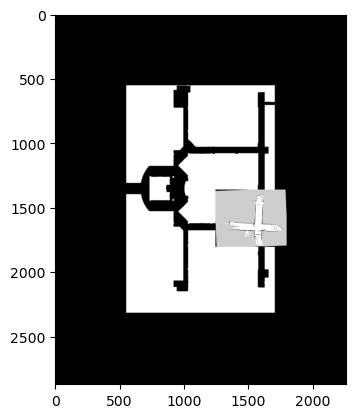

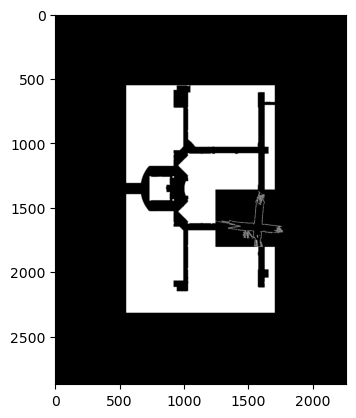

In [94]:
# params:
# global_map - matlike, represents the global map
# local_map - matlike, represents the local map
# pose_est - (x, y, r), position and rotation of pose estimate
# rotation_sigma - tightness of rotation estimate in degrees
# distribution_sigma - tightness of point estimation distribution in pixels
# num_points - number of points to generate
# num_iter - number of iterations to resample
def localize(global_map, local_map, pose_est, rotation_sigma=3, gaussian_sigma=5, distribution_sigma=50, num_points=50, num_iter=1, iter_tightness_constraint=1):

    local_walls = np.zeros(local_map.shape, dtype=np.float32)
    local_walls[local_map == 255] = 0
    local_walls[local_map == 205] = 255
    local_mag , local_ang = setup_map(local_walls)

    ksize = int(gaussian_sigma*10)
    if ksize % 2 == 0: ksize+=1
    global_blur = cv2.GaussianBlur(global_map, (ksize,ksize), gaussian_sigma, gaussian_sigma)
    _, global_ang = setup_map(global_blur)
    global_ang = np.pad(global_ang, pad_width=max(local_map.shape), constant_values=np.nan)

    points = np.random.multivariate_normal(pose_est[0], [[distribution_sigma, 0],[0, distribution_sigma]], num_points)

    angles = np.random.normal(pose_est[1], rotation_sigma, num_points)
    points = np.concatenate((points, angles[:, np.newaxis]), axis=1)
    

    h, w = local_walls.shape
    weights = []
    x = int(pose_est[0][0])
    y = int(pose_est[0][1])
    weights.append(np.nansum(calc_weight(global_ang, local_ang, local_mag, (x,y))))
    for point in points:
        rotation_matrix = cv2.getRotationMatrix2D((w/2,h/2), point[2], 1)
        rotated_ang = cv2.warpAffine(local_ang, rotation_matrix, (w,h), borderValue=np.nan)
        rotated_mag = cv2.warpAffine(local_mag, rotation_matrix, (w,h), borderValue=0)
        x = int(point[0])
        y = int(point[1])
        weights.append(np.nansum(calc_weight(global_ang, rotated_ang, rotated_mag, (x,y))))

    plt.imshow(global_map)
    max_weight = max(weights)
    max_index = weights.index(max_weight)
    best_point = points[max_index]
    if num_iter > 1:
        p, w = localize(global_map,
                         local_map, 
                         ((best_point[0],best_point[1]),best_point[2]), 
                         rotation_sigma=rotation_sigma*iter_tightness_constraint, 
                         distribution_sigma=distribution_sigma*iter_tightness_constraint,
                         num_points=num_points,
                         num_iter=num_iter-1,
                         gaussian_sigma=gaussian_sigma*iter_tightness_constraint,
                         iter_tightness_constraint=iter_tightness_constraint)
        if w > max_weight:
            best_point = p

    return best_point, max(weights)

best_point, _ = localize(global_map, local_map, ((800,700), 0), num_iter=3, num_points=200, iter_tightness_constraint=0.5)
h,w = local_map.shape


rotation_matrix = cv2.getRotationMatrix2D((w/2,h/2), best_point[2], 1)
rotated_map = cv2.warpAffine(local_map, rotation_matrix, (w,h), borderValue=np.nan)
x = int(best_point[0])
y = int(best_point[1])
padsize = max(w,h)
new_map = np.copy(global_map)
new_map = np.pad(new_map, padsize, constant_values=np.nan)
new_map[x+padsize:x+padsize+h, y+padsize:y+padsize+w] = rotated_map
print(best_point)
plt.imshow(new_map, cmap='gray')
plt.show()
new_map[x+padsize:x+padsize+h, y+padsize:y+padsize+w] = local_mag
plt.imshow(new_map, cmap='gray')
plt.show()

